In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


import os
from dotenv import load_dotenv
load_dotenv()


from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [3]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="llama-3.1-8b-instant")

In [4]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://huggingface.co/learn/agents-course/en/unit2/langgraph/when_to_use_langgraph',
   'title': 'What is LangGraph ? - Hugging Face Agents Course',
   'content': '# What is LangGraph ? `LangGraph` is a framework developed by LangChain **to manage the control flow of applications that integrate an LLM**. ## When should I use LangGraph ? `LangGraph` is on the other end of the spectrum, it shines when you need **“Control”** on the execution of your agent. LangGraph is particularly valuable when you need **Control over your applications**. It gives you the tools to build an application that follows a predictable process while still leveraging the power of LLMs. Put simply, if your application involves a series of steps that need to be orchestrated in a specific way, with decisions being made at each junction point, **LangGraph provides the structure you need**. ## How does L

In [5]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [6]:
tools=[tool, multiply]

In [7]:
llm_with_tool=llm.bind_tools(tools)

In [8]:
llm_with_tool

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001A7FD99E7B0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A7FD99F4D0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input sho

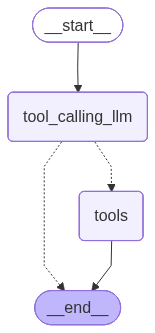

In [9]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
response=graph.invoke({"messages":"What is 58756 times 93453463. what are the latest updates on ai?"})

In [11]:
response

{'messages': [HumanMessage(content='What is 58756 times 93453463. what are the latest updates on ai?', additional_kwargs={}, response_metadata={}, id='71afca2f-b04e-4573-ba4b-19953576e5ef'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v574k8va5', 'function': {'arguments': '{"a":58756,"b":93453463}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 1764, 'total_tokens': 1807, 'completion_time': 0.066234028, 'completion_tokens_details': None, 'prompt_time': 0.099027145, 'prompt_tokens_details': None, 'queue_time': 0.047081784, 'total_time': 0.165261173}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c8135-bcd5-7403-9945-2809dcec3d85-0', tool_calls=[{'name': 'multiply', 'args': {'a': 58756, 'b': 93453463}, 'id': 'v574k8va5', 'type': 'tool_call'}], 

In [22]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1c42qwrek)
 Call ID: 1c42qwrek
  Args:
    query: Recent AI news
    search_depth: advanced
    time_range: day
    topic: news
  multiply (g8p0m7dns)
 Call ID: g8p0m7dns
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "Recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.sciencedaily.com/releases/2026/02/260221060942.htm", "title": "Generative AI analyzes medical data faster than human research teams - ScienceDaily", "score": 0.93581736, "published_date": "Sat, 21 Feb 2026 11:19:58 GMT", "content": "---\n\nYour source for the latest research news\n\nFollow: Facebook X/Twitter Subscribe: RSS Feeds New

### ReAct Agent Architecture

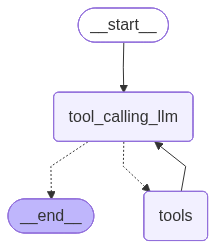

In [23]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")    # just changed here

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7btqw59rs)
 Call ID: 7btqw59rs
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_images: False
    query: Recent AI news
    search_depth: advanced
    start_date: None
    time_range: day
    topic: news
  multiply (3cpqqv9bj)
 Call ID: 3cpqqv9bj
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "Recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nbcnews.com/video/concerns-are-growing-over-chatbots-causing-users-to-go-into-delusional-spirals-258067525827", "title": "Concerns are growing over chatbots causing users to go into 'delusional spirals' - NBC News", "